In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0,'../../')

In [5]:
from torchtrainer import img_util, transforms
import imgaug as ia
import imgaug.augmenters as iaa
from pathlib import Path
from functools import partial
import re
import numpy as np
import matplotlib.pyplot as plt
import torch

In [3]:
def name_2_label_map(img_filename):
    '''Maps image names to labels names in the DRIVE dataset
    
    Parameters
    ----------
    img_filename : string
        Filename of an image
        
    Returns
    -------
    label_filename : string
        Filename of the corresponding label image
    '''  
    
    m = re.match('(\d\d)_[training|test]', img_filename)
    index = m.group(1)
    label_filename = index + '_manual1.gif'
    
    return label_filename


root_dir = Path('../../../research/drive/data/DRIVE')
img_dir = root_dir/'images'
label_dir = root_dir/'labels'

# Create functions for using in the dataset creation
img_opener_partial = partial(img_util.pil_img_opener, channel=None)
label_opener_partial = partial(img_util.pil_img_opener, is_label=True)

files = list(img_dir.iterdir())
img_pil = img_opener_partial(files[0])
label_pil = label_opener_partial(label_dir/name_2_label_map(files[0].stem))

#img_pil = img_pil.convert('L')

In [8]:
img, label = transforms.TransfToNumpy()(img_pil, label_pil)

In [242]:
ctnp = transforms(to='numpy')
img = ctnp(img_pil)

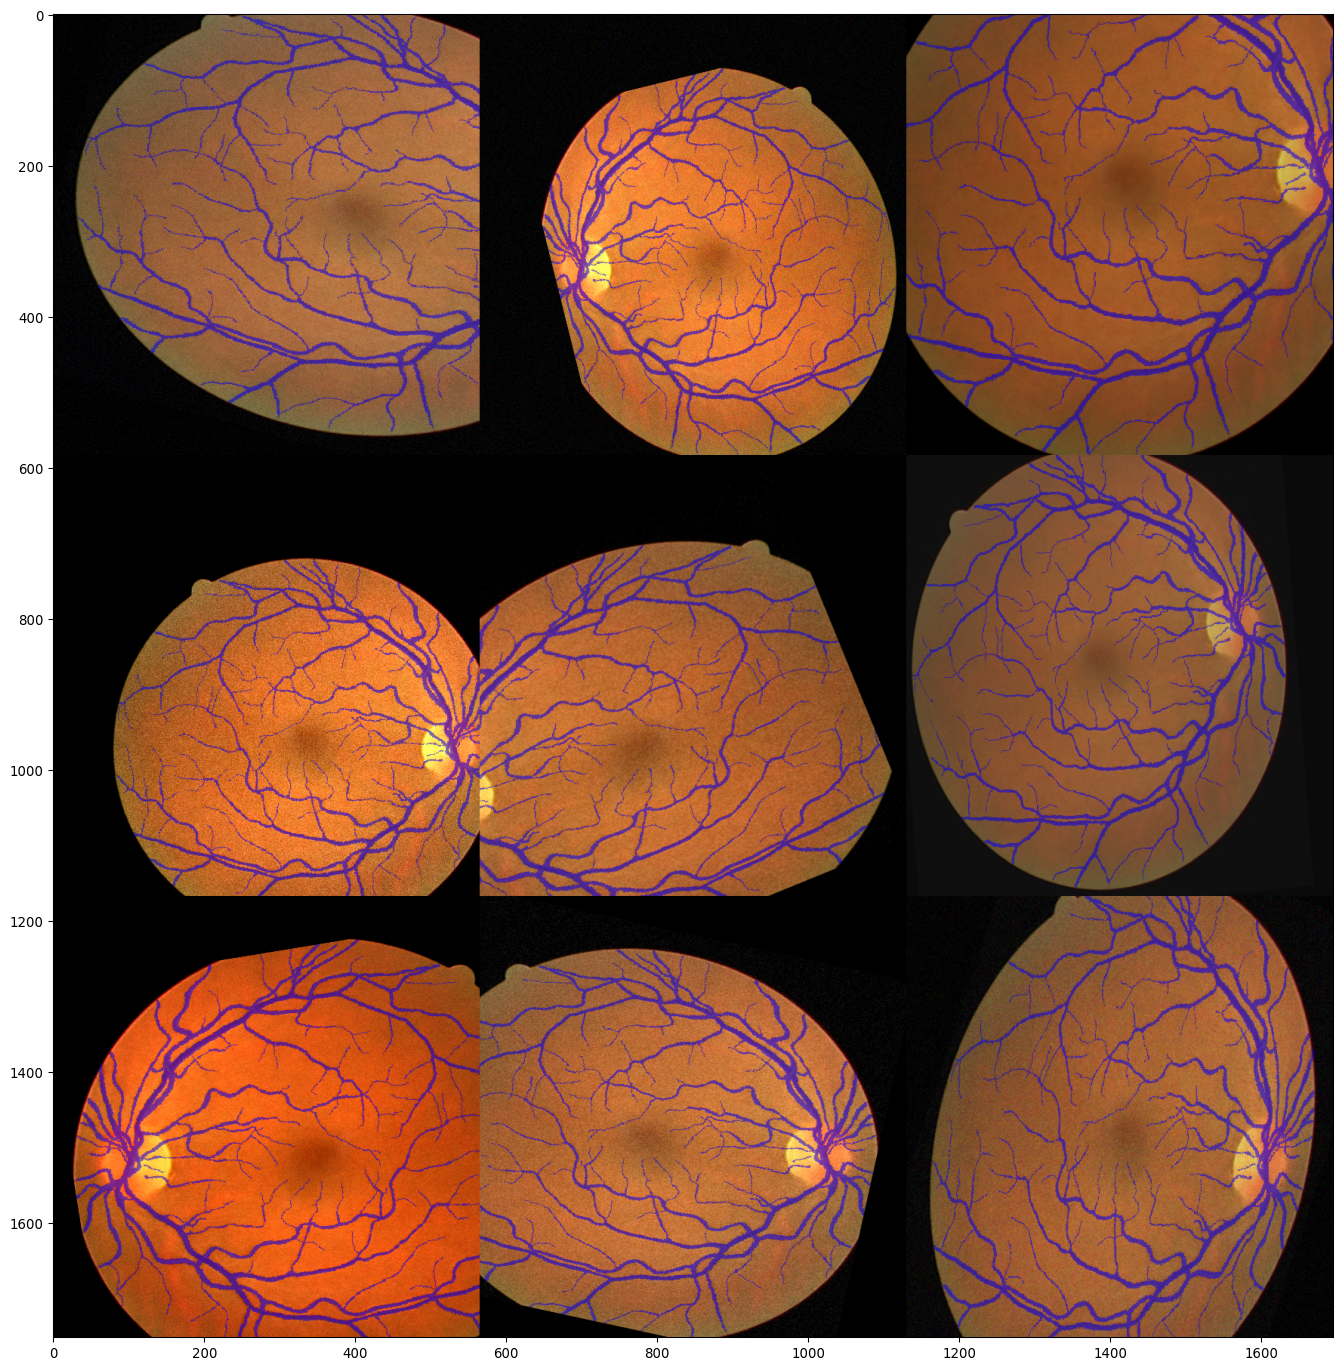

In [9]:
import numpy as np
from torchtrainer.imagedataset import ImageSegmentationDataset

ia.seed(1)


seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    iaa.Crop(percent=(0, 0.1)), # random crops
    iaa.Sometimes(
        0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    iaa.LinearContrast((0.75, 1.5)),
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    )
], random_order=True) # apply augmenters in random order

segmap = ia.SegmentationMapsOnImage(label, img.shape)
image_aug, segmap_aug = zip(*[seq(image=img, segmentation_maps=segmap) for _ in range(9)])
ia.show_grid([segmap_aug[i].draw_on_image(image_aug[i], colors=[[0,0,0],[0,0,255]], alpha=0.5)[0] for i in range(len(segmap_aug))])